# Model Evaluation

In [1]:
seed = 1

import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_curve,roc_auc_score, brier_score_loss, average_precision_score, confusion_matrix, plot_precision_recall_curve, precision_score, recall_score, f1_score

np.random.RandomState(seed=seed)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 11})

x_train = pd.read_csv('processed_data\\x_train.csv')
x_train = x_train.drop(x_train.columns[0],axis=1)
y_train = pd.read_csv('processed_data\\y_train.csv')
y_train = y_train.drop(y_train.columns[0],axis=1)
y_train = y_train.T.squeeze()

x_test = pd.read_csv('processed_data\\x_test.csv')
x_test = x_test.drop(x_test.columns[0],axis=1)
y_test = pd.read_csv('processed_data\\y_test.csv')
y_test = y_test.drop(y_test.columns[0],axis=1)
y_test = y_test.T.squeeze()
best_model = joblib.load(f'pickled_objects\\LVTRES_best_model.pkl')

bootstrap_reps = 2000

In [2]:
def bootstrap_statistics(clf,x_test,y_test,bootstrap_reps):
    """
    Nonparametric bootstrap to obtain confidence intervals for model performance on the test set.
    
    Parameters
    ----------
    clf: sklearn.Estimator
        A fitted sklearn model
    x_test: array-like
        Array of test set predictors
    y_test: array-like
        Array of test set labels
    bootstrap_reps: int
        Number of bootstrap replicates
    
    Returns
    -------
    output_dict: dict
        A nested dictionary containing the bootstrap results for the following summary statistics: AUROC, AUPRC, Sensitivity, Specificity, PPV
        Also contains a nested list of indices for each bootstrap value 
    
    """
    bs_auprc = []
    bs_auc = []
    bs_sensitivity = []
    bs_specificity = []
    bs_ppv = []
    index_list = []
    for i in range(bootstrap_reps):
        idx = np.random.choice(np.array(range(len(x_test))),size=len(x_test),replace=True)
        y_pred_proba = clf.predict_proba(x_test.iloc[idx])[::,1]
        ap_score = average_precision_score(y_test[idx], y_pred_proba)
        bs_auprc.append(ap_score)
        auc_score = roc_auc_score(y_test[idx], y_pred_proba)
        bs_auc.append(auc_score)
        tn, fp, fn, tp = confusion_matrix(y_test[idx], y_pred_proba >= 0.5).ravel()
        sensitivity = tp/(tp+fn) 
        specificity = tn/(tn+fp)
        ppv = tp/(tp+fp)
        bs_sensitivity.append(sensitivity)
        bs_specificity.append(specificity)
        bs_ppv.append(ppv)
        index_list.append(idx.tolist())
    
    output_dict = {'auprc':bs_auprc,'auc':bs_auc,'sensitivity':bs_sensitivity,'specificity':bs_specificity,'ppv':bs_ppv,'indices':index_list}
    
    return output_dict
    
bootstrap_dict = bootstrap_statistics(best_model,x_test,y_test,bootstrap_reps=bootstrap_reps)

In [3]:
def get_closest_index(lst,value):
    """
    Function to get the closest index of a value in a list
    
    Parameters
    ----------
    lst: list
        A list where you want to find an index of a value
    value: float64
        A value of interest
        
    Returns
    -------
    index: int
        The index of the closest value to the input value in lst
    """
    try:
        closest_value = min(lst, key=lambda x:abs(x-value))
    except Exception as e:
        raise e
    index = lst.index(closest_value)
    return index

def mean_95ci(lst,index_list):
    """
    A function to obtain the mean and 95% confidence intervals from a list of boostrapped results
    
    Parameters
    ----------
    lst: list
        A list of bootstrap results
    index_list: lst
        A list of indices for the test set data used during bootstrap resampling
    
    Returns
    -------
    mean: float64
        Bootstrap mean for the statistic of interest
    lowerbound: float64
        Bootstrap 2.5% quantile for the statistic of interest
    upperbound: float64
        Bootstrap 97.% quantile for the statistic of interest
    mean_indices:
        Indices of the test set data used to obtain the bootstrap mean
    lower_indices:
        Indices of the test set data used to obtain the bootstrap 2.5% quantile
    upper_indices:
        Indices of the test set data used to obtain the bootstrap 97.5% quantile
    """
    
    array = np.array(lst)

    lowerbound = np.quantile(array,0.025)
    lower_indices = get_closest_index(lst,lowerbound)
    lowerbound = np.round(lowerbound,3)

    upperbound = np.quantile(array,0.975)
    upper_indices = get_closest_index(lst,upperbound)
    upperbound = np.round(upperbound,3)

    mean = np.mean(array)
    mean_indices = get_closest_index(lst,mean)
    mean = np.round(mean,3)

    mean_indices = index_list[mean_indices]
    lower_indices = index_list[lower_indices]
    upper_indices = index_list[upper_indices]
    
    return mean, lowerbound, upperbound, (mean_indices,lower_indices,upper_indices)

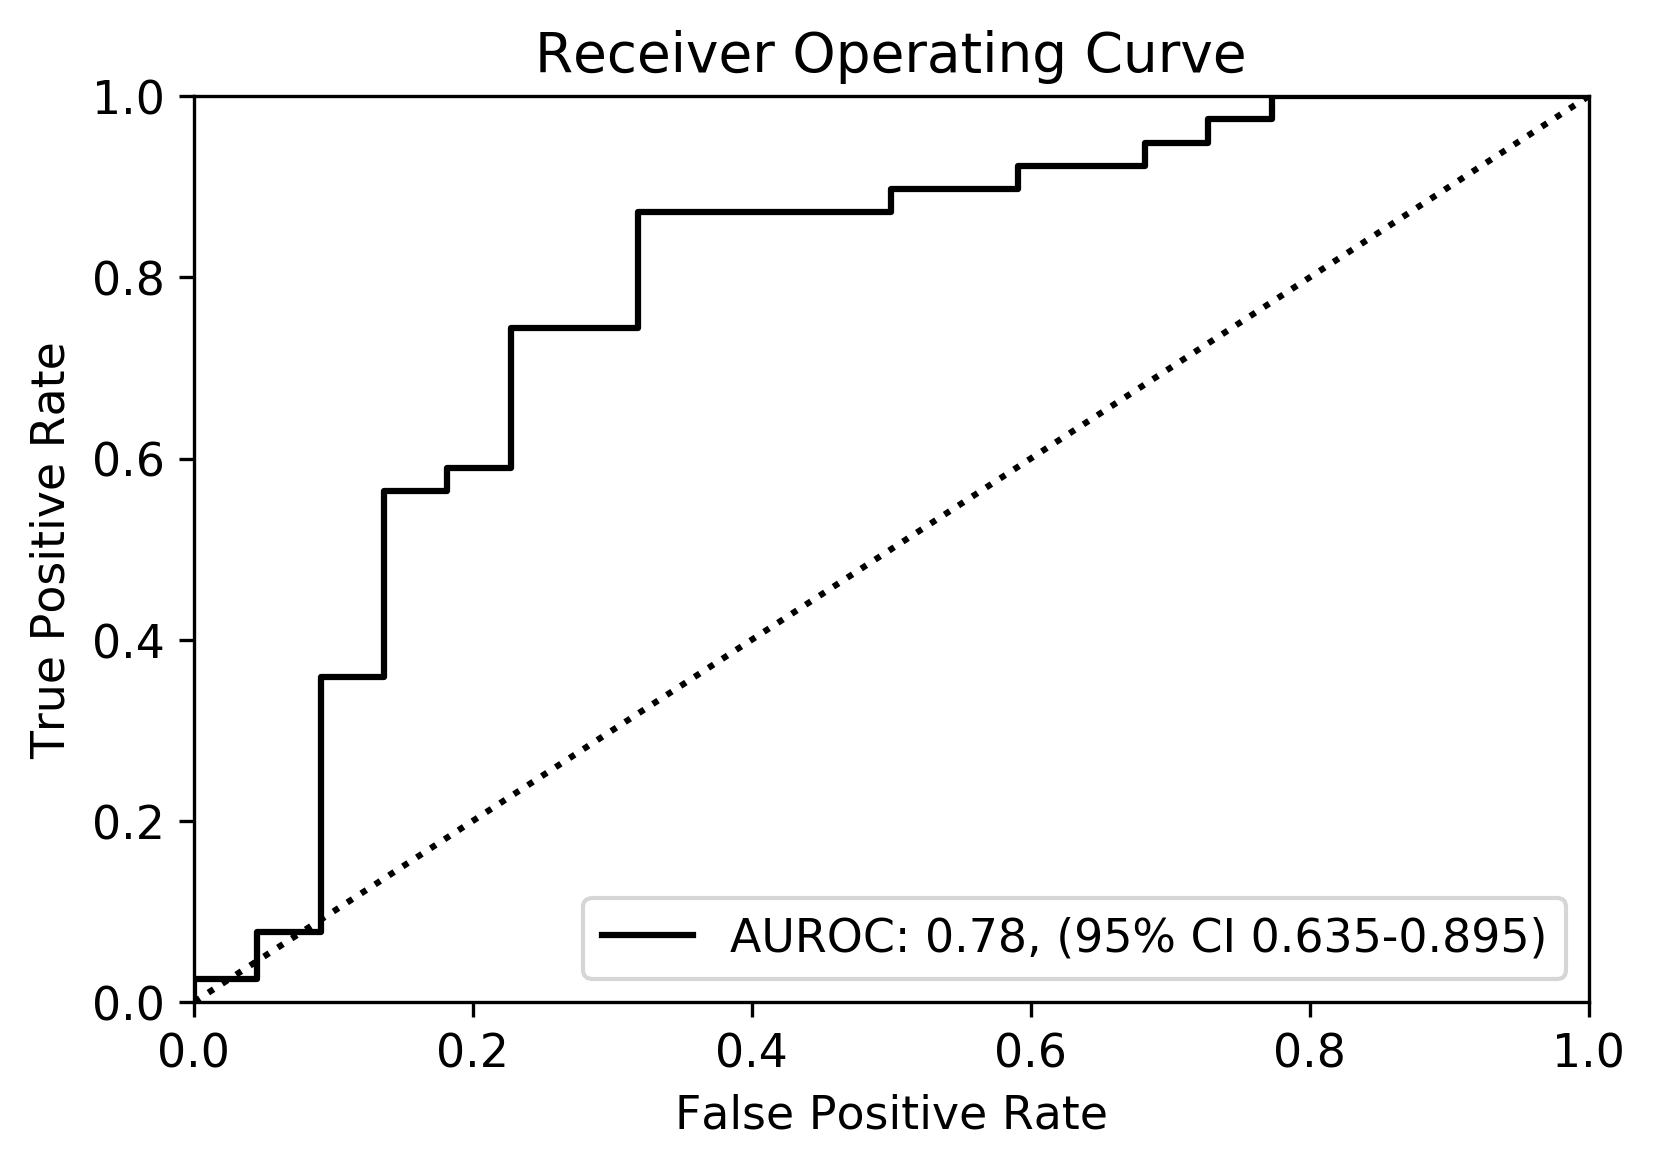

In [4]:
def get_auc_plot(clf,mean,lowerbound,upperbound,index_tpl):
    """
    Function to plot a Receiver Operating Characteristic
    
    Ripped from Sklearn documentation
    
    Parameters
    ----------
    clf: sklearn.Estimator
        A fitted sklearn model
    mean: float64
        Bootstrap mean of AUROC
    lowerbound: float64
        Bootstrap 2.5% quantile of AUROC
    upperbound: float64
        Bootstrap 97.5% quantile of AUROC
    index_tpl: tuple
        Indices of testing data for mean, lower and upper bound results
        
    Returns
    -------
    None
    
    """
    from sklearn.metrics import roc_auc_score
    
    #Get test set scores
    y_pred_proba = clf.predict_proba(x_test)[::,1]
    test_fpr, test_tpr, _ = roc_curve(y_test,  y_pred_proba)
    test_set = roc_auc_score(y_test,y_pred_proba)
    
    #Get lowerbound
    y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[1]])[::,1]
    lower_fpr, lower_tpr, _ = roc_curve(y_test[index_tpl[1]],  y_pred_proba)
    
    #Get upperbound
    y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[2]])[::,1]
    upper_fpr, upper_tpr, _ = roc_curve(y_test[index_tpl[2]],  y_pred_proba)
    
    label_string = f'AUROC: {np.round(test_set,3)}, (95% CI {lowerbound}-{upperbound})'
    print()
    plt.title('Receiver Operating Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.plot([1, 0], [1, 0],"k:")
    plt.plot(test_fpr,test_tpr,label=label_string,color='black')
    plt.legend(loc=4)
    plt.show()
    
auc_mean,auc_lowerbound,auc_upperbound,index_tpl = mean_95ci(bootstrap_dict['auc'],bootstrap_dict['indices'])
get_auc_plot(best_model,auc_mean,auc_lowerbound,auc_upperbound,index_tpl)

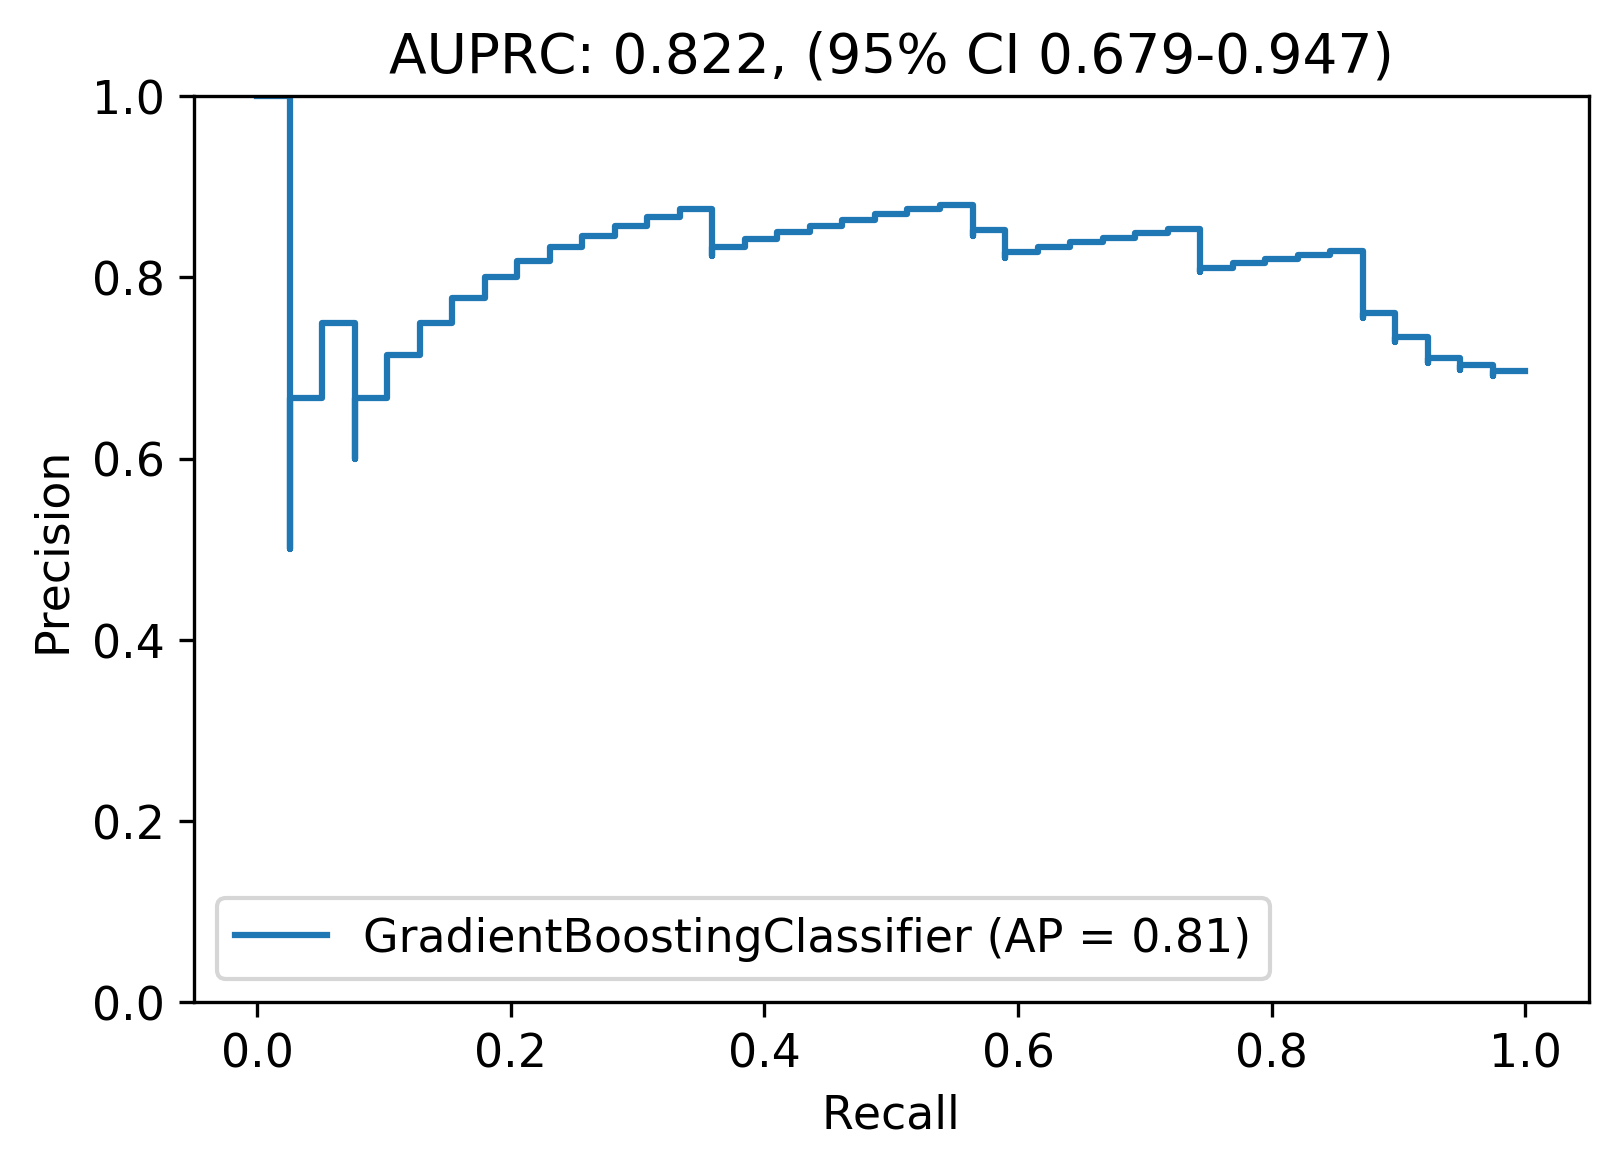

In [5]:
def get_auprc_plot(clf,mean,lowerbound,upperbound):
    
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(x_test)[:, 1]
    else:  # use decision function
        y_score = clf.decision_function(x_test)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
                
    label_string = f'AUPRC: {mean}, (95% CI {lowerbound}-{upperbound})'
    disp = plot_precision_recall_curve(clf, x_test, y_test)
    disp.ax_.set_ylim(0,1.0)
    disp.ax_.set_title(label_string)
    
auprc_mean,auprc_lowerbound,auprc_upperbound,_ = mean_95ci(bootstrap_dict['auprc'],bootstrap_dict['indices'])
get_auprc_plot(best_model,auprc_mean,auprc_lowerbound,auprc_upperbound)

In [7]:
print('Additional Metrics - at cutoff p = 0.5')
y_score = best_model.predict_proba(x_test)[:, 1]
tn, fp, fn, tp = confusion_matrix(y_test, y_score >= 0.5).ravel()
sensitivity = tp/(tp+fn) 
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)

_,sensitivity_lowerbound,sensitivity_upperbound,_ = mean_95ci(bootstrap_dict['sensitivity'],bootstrap_dict['indices'])
print(f'Sensitivity: {np.round(sensitivity,3)} (95% CI {sensitivity_lowerbound}-{sensitivity_upperbound})')
_,specificity_lowerbound,specificity_upperbound,_ = mean_95ci(bootstrap_dict['specificity'],bootstrap_dict['indices'])
print(f'Specificity: {np.round(specificity,3)} (95% CI {specificity_lowerbound}-{specificity_upperbound})')
_,ppv_lowerbound,ppv_upperbound,_ = mean_95ci(bootstrap_dict['ppv'],bootstrap_dict['indices'])
print(f'Positive Predictive Value: {np.round(ppv,3)} (95% CI {ppv_lowerbound}-{ppv_upperbound})')

Additional Metrics - at cutoff p = 0.5
Sensitivity: 0.769 (95% CI 0.628-0.895)
Specificity: 0.682 (95% CI 0.474-0.864)
Positive Predictive Value: 0.811 (95% CI 0.677-0.923)


# Feature Importance

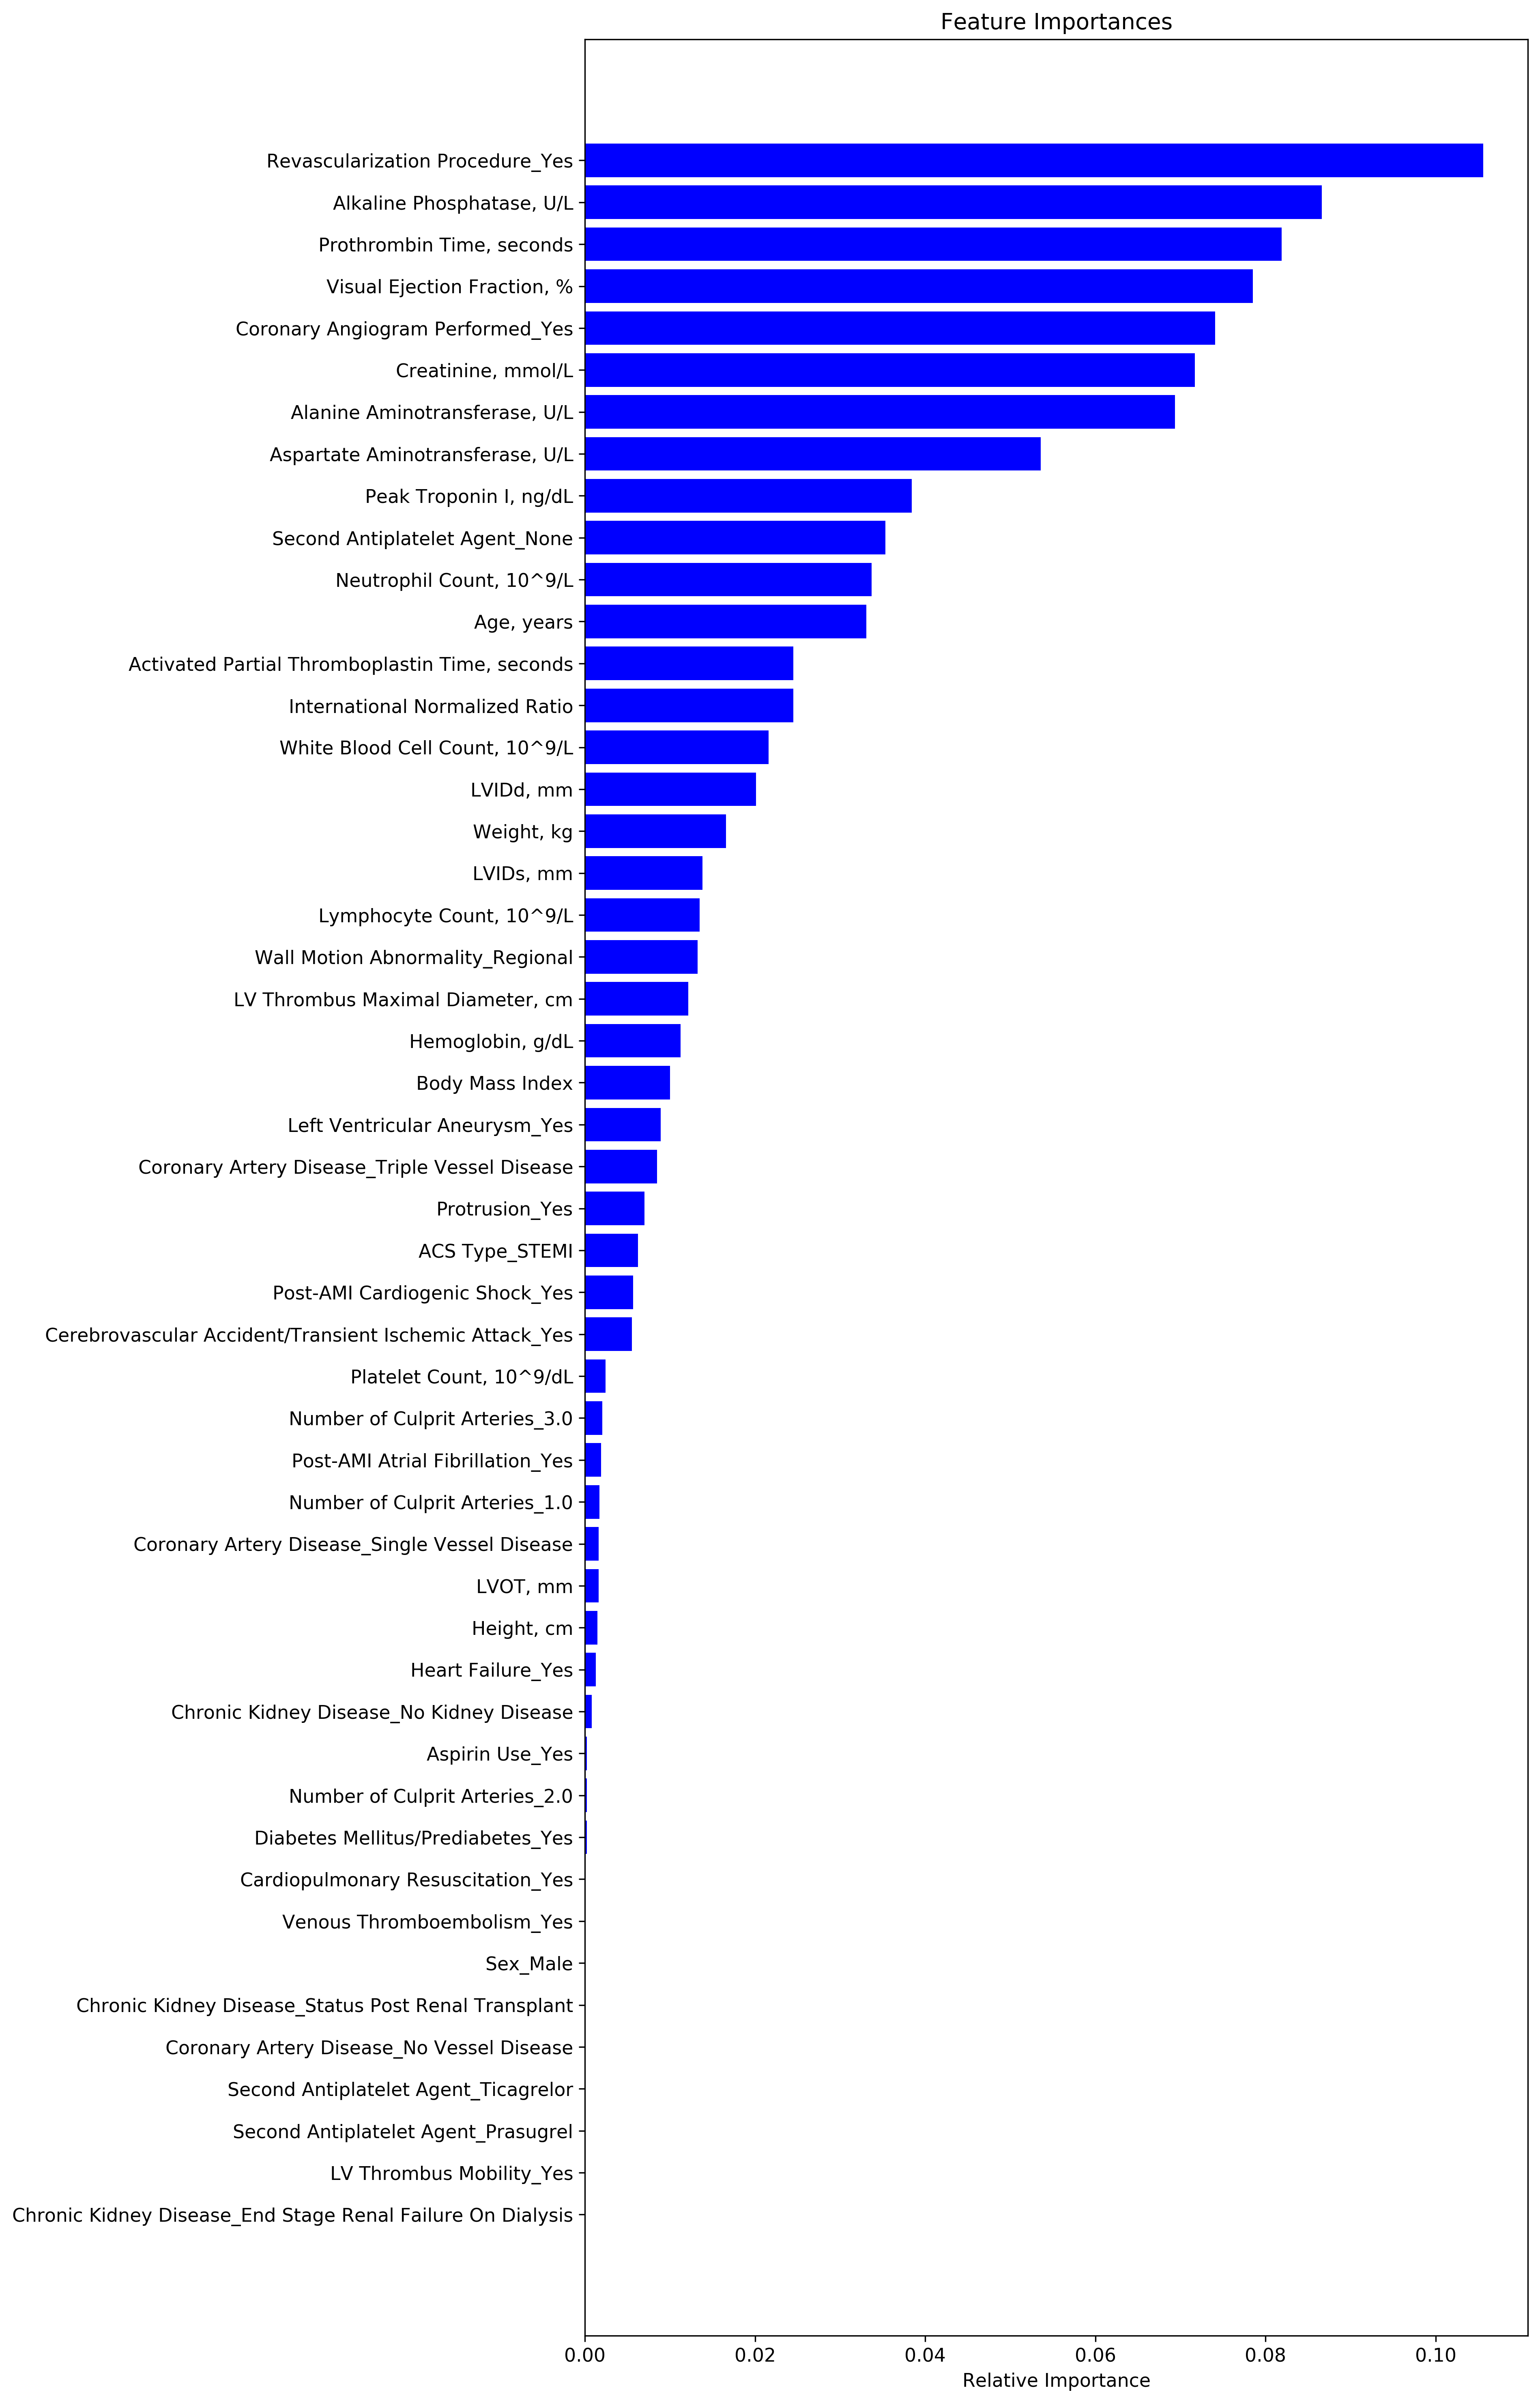

In [8]:
if hasattr(best_model,'feature_importances_'):
    features = x_test.columns
    importances =  best_model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10,25))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Calibration

Best Model:
	Brier: 0.174
	Precision: 0.811
	Recall: 0.769
	F1: 0.789

Best Model + Isotonic:
	Brier: 0.192
	Precision: 0.806
	Recall: 0.744
	F1: 0.773

Best Model + Sigmoid:
	Brier: 0.189
	Precision: 0.829
	Recall: 0.744
	F1: 0.784



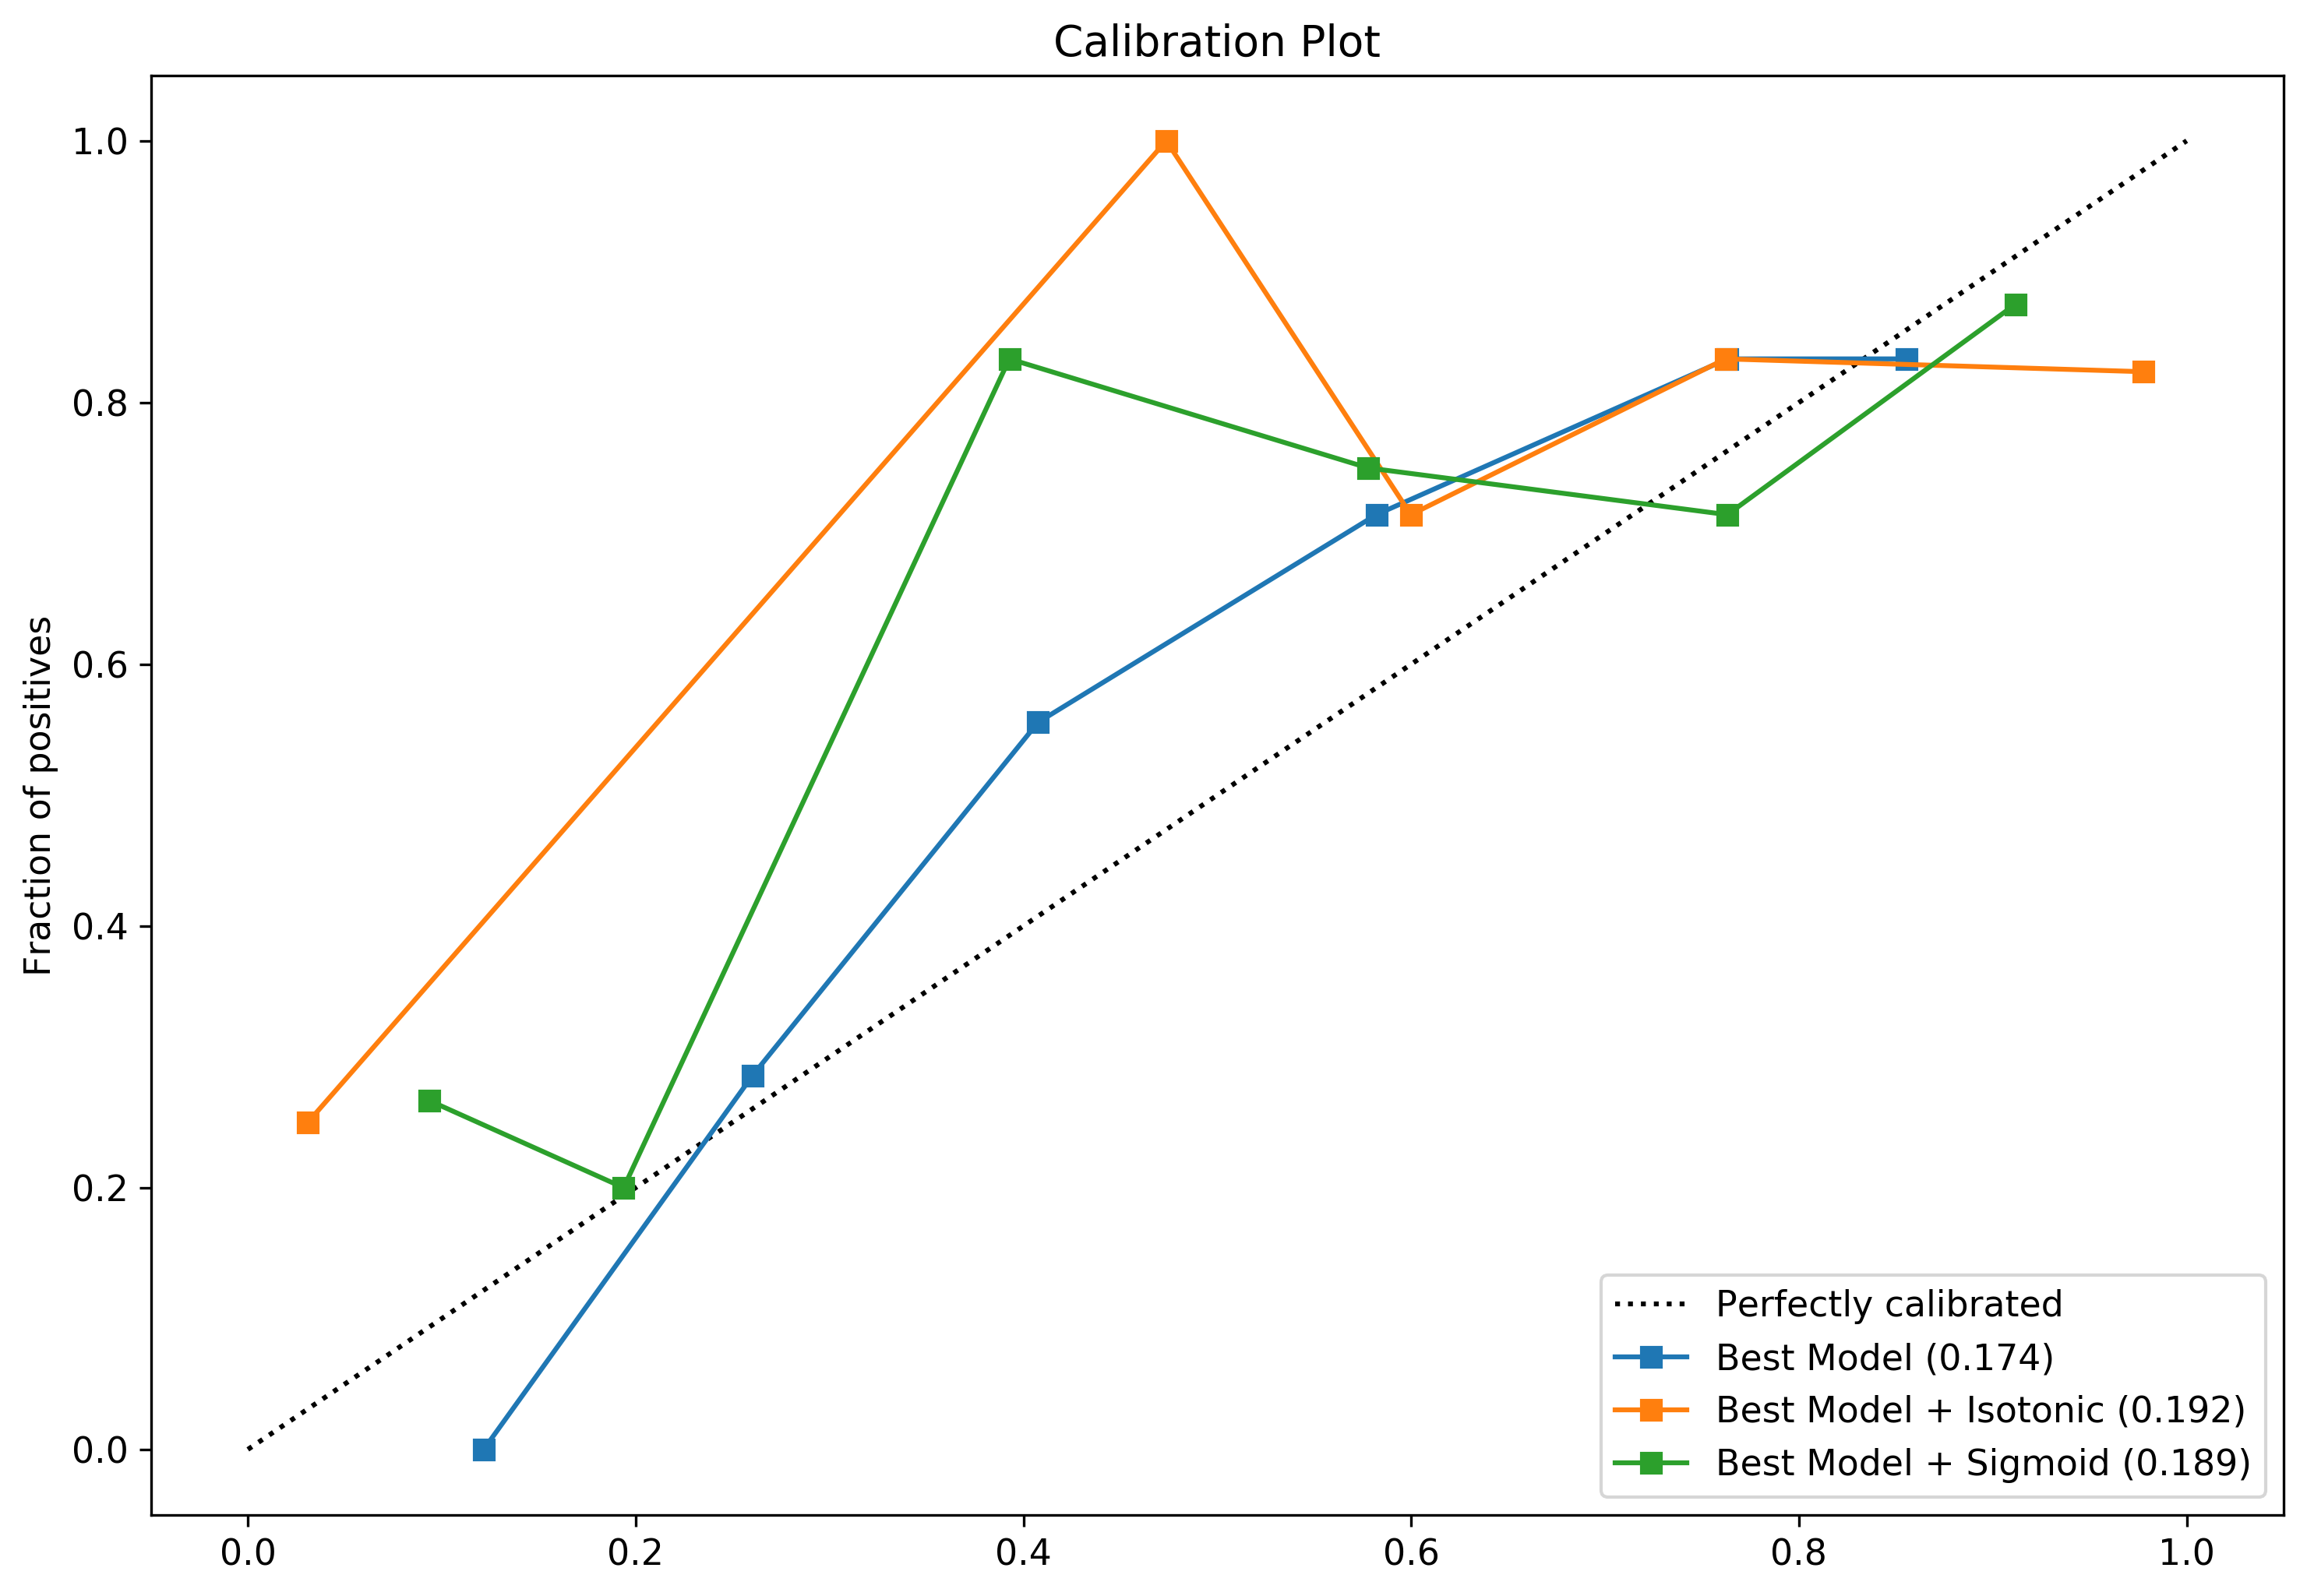

In [9]:
def plot_calibration_curve(est, name, fig_index,cv='prefit'):
    """
    Ref: https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py
    """        
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=cv, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=cv, method='sigmoid')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    #ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(x_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(x_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)

        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=6)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration Plot')

    plt.tight_layout()

plot_calibration_curve(best_model, 'Best Model', 1,cv='prefit')

# Final Plots

In [10]:
title_auc='Figure 1A. Receiver Operating Curve'
title_calibration='Figure 1B. Calibration Plot'
clf = best_model
    
#Get test set scores
y_pred_proba = clf.predict_proba(x_test)[::,1]
test_fpr, test_tpr, _ = roc_curve(y_test,  y_pred_proba)
test_set = roc_auc_score(y_test,y_pred_proba)

y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[1]])[::,1]
lower_fpr, lower_tpr, _ = roc_curve(y_test[index_tpl[1]],  y_pred_proba)

y_pred_proba = clf.predict_proba(x_test.iloc[index_tpl[2]])[::,1]
upper_fpr, upper_tpr, _ = roc_curve(y_test[index_tpl[2]],  y_pred_proba)

label_string = f'AUROC: {np.round(test_set,2)} (95% CI {auc_lowerbound}-{auc_upperbound})'

prob_pos = clf.predict_proba(x_test)[::,1]
clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=6)

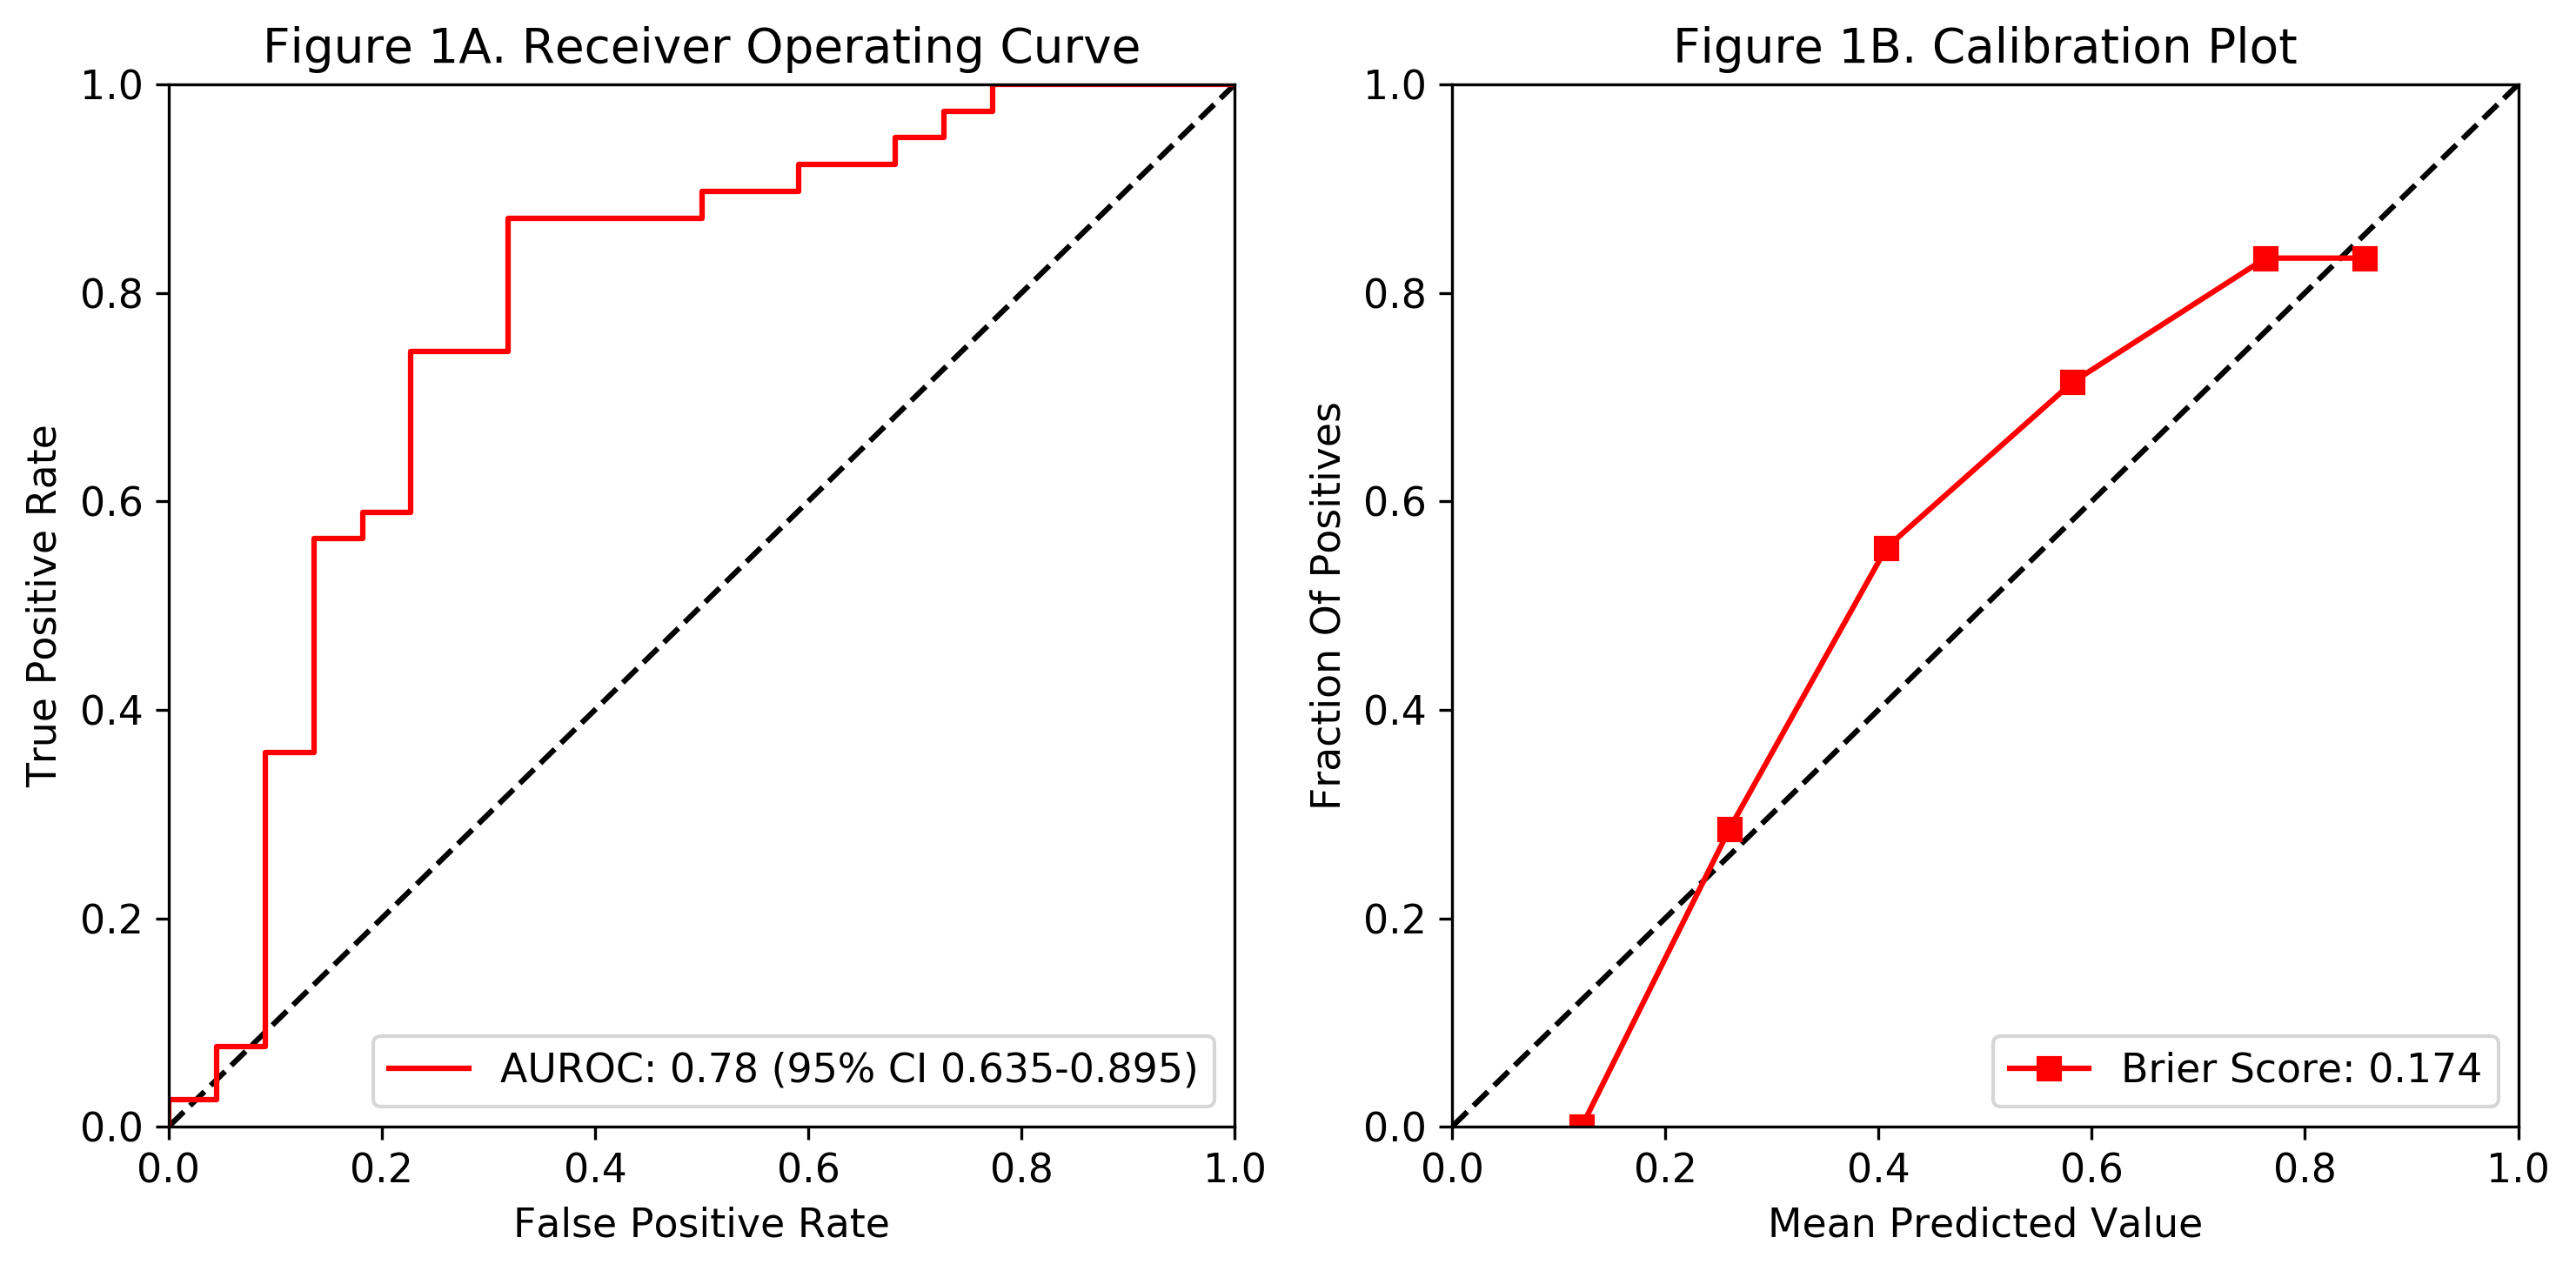

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title(title_auc)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([1, 0], [1, 0],"k--")
plt.plot(test_fpr,test_tpr,label=label_string,color='red')
plt.legend(loc=4)

plt.subplot(1,2,2)
plt.title(title_calibration)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel("Fraction Of Positives")
plt.xlabel("Mean Predicted Value")
plt.plot([1, 0], [1, 0],"k--")
plt.plot(mean_predicted_value, fraction_of_positives, "rs-",label=f'Brier Score: {np.round(clf_score,3)}')
plt.legend(loc="lower right")
plt.savefig('Figure 1.png')
plt.tight_layout()

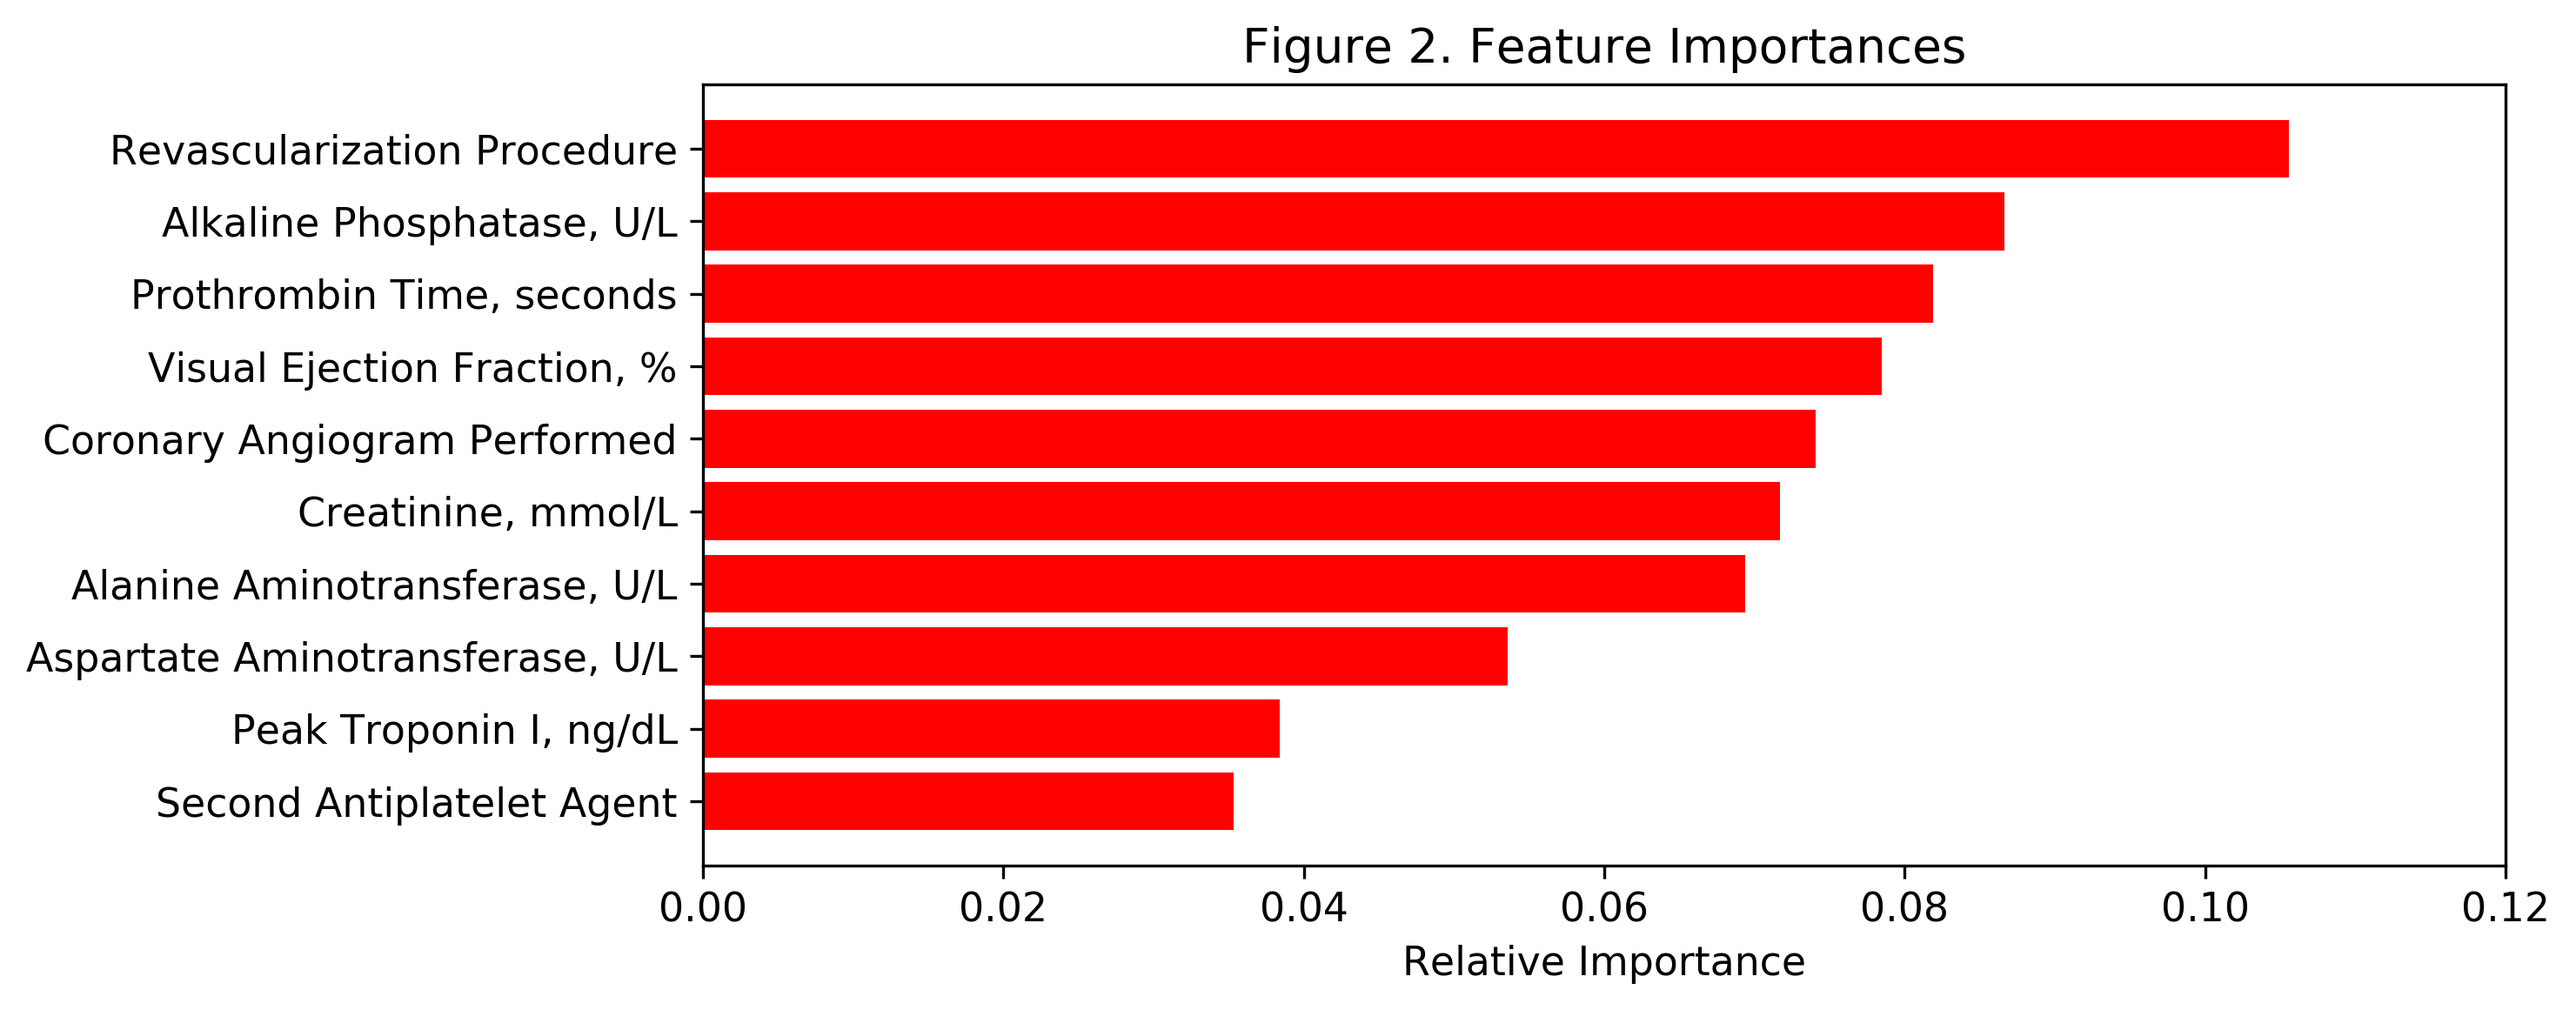

In [16]:
if hasattr(best_model,'feature_importances_'):
    features = x_test.columns
    importances =  best_model.feature_importances_
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(10,4))
    plt.title('Figure 2. Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i].split('_')[0] for i in indices])
    plt.xlabel('Relative Importance')
    plt.xlim(0,0.12)
    plt.tight_layout()
    plt.savefig('Figure 2.png')
    plt.show()